In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import shuffle
import re

dataset_path = "./dataset"
glove_path = f"{dataset_path}/glove"

In [2]:
from os import path

# download Glove Dataset
if not path.exists("./dataset/glove/"):
    !wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip -O ./glove.6B.zip 
    !mkdir dataset/glove
    !mv ./glove.6B.zip dataset/glove
    !cd dataset/glove && unzip ./glove.6B.zip

--2022-06-21 08:38:46--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
Resolving huggingface.co (huggingface.co)... 3.208.54.125, 34.197.58.156, 34.198.184.113, ...
Connecting to huggingface.co (huggingface.co)|3.208.54.125|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a?response-content-disposition=attachment%3B%20filename%3D%22glove.42B.300d.zip%22 [following]
--2022-06-21 08:38:47--  https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a?response-content-disposition=attachment%3B%20filename%3D%22glove.42B.300d.zip%22
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 18.66.218.53, 18.66.218.56, 18.66.218.17, ...
Connecting to cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)|18.66.218.53|:443... connected.
HTTP request sent, awaiting response... 20

In [6]:
dataset = pd.read_csv(f'{dataset_path}/train.csv')
dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [7]:
def words_to_indices(words: pd.Series) -> list:
    """
        Questa funzione va ad assegnare un ID unico (parte da 0) ad ogni elemento della serice (colonna)
        che gli viene passato.

        E.g.
            input:  pd.Series(['a', 'b', 'a', 'c', 'd', 'c'])
            output: [(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd')]
    """

    enumeration = enumerate(words.unique()) # prende ogni elemento 1 sola volta
                                            # funzione unique() fa si che ad ogni run l'ordine della parole sia lo stesso
                                            # a differenza di set()
    
    return list(enumeration)

# assegna degli indici alle label della colonna discourse_type e discourse_effectiveness
type_label_index = words_to_indices(dataset["discourse_type"])
effectiveness_label_index = words_to_indices(dataset["discourse_effectiveness"])

# creo le due nuove colonne
dataset["type_label"] = dataset["discourse_type"]
dataset["effectiveness_label"] = dataset['discourse_effectiveness']

# rimpiazzo gli elementi dalle nuove colonne con quelli corretti (gli indici numerici)
for new_value, old_value in effectiveness_label_index:
    dataset["effectiveness_label"].replace(old_value, new_value, inplace=True)

for new_value, old_value in type_label_index:
    dataset["type_label"].replace(old_value, new_value, inplace=True)

In [8]:
dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,type_label,effectiveness_label
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0,0
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,1,0
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,2,0
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,3,0
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,4,0


In [11]:
def clean_text(text, huge_changes=False):
    # TODO: vedere se vanno rimosse oppure no !
    if huge_changes:
        ## Remove puncuation
        text = text.translate(string.punctuation)

        ## Remove stop words
        text = text.lower().split() #default separator is any whitespace.
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops and len(w) >= 3]   # no stop words and no words less than 3 chars
        text = " ".join(text)    ## Clean the text
    
    ## Convert words to lower case and split them
    text = text.lower() # lo split solo per togliere le stopword

    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text) #Here is a regex to match a string of characters that are not a letters or numbers 0-9 to match numbers
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)

    text = re.sub(r"\/", " ", text)
    #text = re.sub(r"\^", " ^ ", text)
    #text = re.sub(r"\+", " + ", text)
    #text = re.sub(r"\-", " - ", text)
    #text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"\n\n", " ", text)  
    '''
    text = re.sub(r"\S,\s", " ,", text)  
    text = re.sub(r"\S,\S", " , ", text)  
    text = re.sub(r"\S!\s", " !", text)
    text = re.sub(r"\S!\S", " ! ", text)
    text = re.sub(r"\S\?\s", " ?", text)
    text = re.sub(r"\S\?\S", " ? ", text)
    text = re.sub(r"\S\.\s", " .", text)  
    text = re.sub(r"\S\.\S", " . ", text)
    text = re.sub(r"\S:\s", " :", text)
    text = re.sub(r"\S:\S", " : ", text)
    '''
    text = re.sub('([\.,!\?():;\-+=^])', r' \1 ', text)
    text = re.sub('\s{2,}', ' ', text)

    text = re.sub(r"[0-9]+", " ", text)  

    if huge_changes:
        text = re.sub(r",", " ", text)
        text = re.sub(r"\.", " ", text)
        ## Stemming
        # TODO: vedere se sta roba puo servire
        text = text.split()
        #print("text2: ", text)
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text] 
        text = " ".join(stemmed_words)

    return text

In [12]:
dataset['discourse_text'] = dataset['discourse_text'].map(lambda x: clean_text(x)) # It executes the function_object for each element in the sequence and 


In [13]:
dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,type_label,effectiveness_label
0,0013cc385424,007ACE74B050,"hi , i am isaac , i am going to be writing abo...",Lead,Adequate,0,0
1,9704a709b505,007ACE74B050,"on my perspective , i think that the face is a...",Position,Adequate,1,0
2,c22adee811b6,007ACE74B050,i think that the face is a natural landform be...,Claim,Adequate,2,0
3,a10d361e54e4,007ACE74B050,"if life was on mars , we would know by now . t...",Evidence,Adequate,3,0
4,db3e453ec4e2,007ACE74B050,people thought that the face was formed by ali...,Counterclaim,Adequate,4,0


In [ ]:
""" X = df["review"].fillna('').to_list()  # no NaN or strange chars
X = [str(i) for i in X]
y = df["label"].fillna('').to_list() """

In [14]:
X = dataset[["discourse_text", "type_label"]]
y = dataset["effectiveness_label"]

In [15]:
X

,discourse_text,type_label
0,"hi , i am isaac , i am going to be writing abo...",0
1,"on my perspective , i think that the face is a...",1
2,i think that the face is a natural landform be...,2
3,"if life was on mars , we would know by now . t...",3
4,people thought that the face was formed by ali...,4
...,...,...
36760,for many people they do not like only asking o...,2
36761,also people have different views and opinions ...,2
36762,advice is something that can impact a persons ...,1
36763,someone can use everything that many people sa...,3


In [16]:
from keras.preprocessing.text import Tokenizer

In [ ]:
RANDOM_STATE = 42

text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)


In [17]:
embeddings_index = dict()

with open(f'{dataset_path}/glove/glove.42B.300d.txt', 'r') as f:
  for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype = "float32")
    embeddings_index[word] = coefs


In [18]:
text = dataset["discourse_text"]

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

In [20]:
vocab_size = len(tokenizer.word_index) + 1 # adding 1 because of reserverd 0 index


In [21]:
vocab_size

27361

In [22]:
embeddings_matrix = np.zeros((vocab_size, 300))   # 50 = embedding dimension
hits = 0
misses = 0

for word, index in tokenizer.word_index.items():
  # print(word, index)
  if index > vocab_size-1:
    break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector
        hits += 1
    else:
      print(word, index)
      misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

elctoral 1739
eletoral 2497
venuse 2519
elctors 2943
electorals 3052
electroal 3514
elecoral 3846
ellectoral 3849
landfrom 4091
ascertainments 4255
oction 4423
electral 4582
inconclusion 4640
lanform 4648
limting 4845
palpabraeus 4871
vaubans 5004
canadidate 5063
risorius 5105
diverless 5303
covid 5304
presendent 5315
electoal 5325
electroral 5618
elecotral 5623
paragrpah 5845
aviods 5970
eletors 5981
electores 5993
elcetion 6002
atomspheric 6157
technollogy 6177
tempetures 6292
eagoing 6336
regared 6447
elcetors 6472
electora 6475
beacuas 6508
vallys 6541
experssions 6565
diffrenet 6654
exspression 6655
sulfric 6657
emotins 6680
fouces 6703
segoing 6769
astronmers 6772
valcanoes 6815
computure 6976
becues 7031
actiry 7048
pharagraph 7051
seegoing 7067
landformation 7125
pleged 7154
recevies 7163
canididate 7165
colloege 7170
democtratic 7192
elecotrs 7217
prisident 7221
elcetoral 7224
electers 7235
alieans 7272
computures 7334
paragrph 7335
planent 7393
soloar 7394
dafted 7405
authoer

In [28]:
from keras_preprocessing.sequence import pad_sequences

In [29]:
discourse_text = tokenizer.texts_to_sequences(dataset["discourse_text"])
maxlen_discourse = max(len(elem) for elem in discourse_text)
discourse_text = pad_sequences(discourse_text, padding="post", maxlen=maxlen_discourse)


In [30]:
maxlen_discourse

837

In [31]:
discourse_text

array([[3626,   17,  219, ...,    0,    0,    0],
       [  18,   84, 1150, ...,    0,    0,    0],
       [  17,   57,    6, ...,    0,    0,    0],
       ...,
       [ 168,    7,  110, ...,    0,    0,    0],
       [ 156,   22,  117, ...,    0,    0,    0],
       [   8,  360,  353, ...,    0,    0,    0]], dtype=int32)

In [34]:
a = []
for i in range(len(discourse_text)):
   a.append([discourse_text[i], dataset["type_label"][i]])
a = np.asarray(a, dtype="object")

In [35]:
a

array([[array([ 3626,    17,   219, 13159,    17,   219,   122,     2,    14,
                 928,    58,    69,    21,    90,    18,   152,     7,     3,
                 340,   296,    26,    25,    37,     7,   118,    18,   152,
                   6,   181,     9,     1,   610,     7,    58,    69,   221,
                 536,     3,   344,     5,   152,     4,     3,    90,    48,
                 591,    18,     1,   139,   221,   147,    11,    77,    25,
                   1,   296,    48,   405,    41,   118,    18,   152,    26,
                  25,     9,     7,    56,     3,   340,   296,     0,     0,
                   0,     0,     0,     0,     0,     0,     0,     0,     0,
                   0,     0,     0,     0,     0,     0,     0,     0,     0,
                   0,     0,     0,     0,     0,     0,     0,     0,     0,
                   0,     0,     0,     0,     0,     0,     0,     0,     0,
                   0,     0,     0,     0,     0,     0,     0, 

In [36]:
x_train, x_test, y_train, y_test = train_test_split(a, dataset["effectiveness_label"], test_size=.2, shuffle=True)


In [38]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(29412, 2)
(7353, 2)
(29412,)
(7353,)


In [51]:
x_train[0][1]


3

In [89]:
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Flatten, Add,Input, Concatenate,Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Reshape, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from transformers import TFAutoModelForMaskedLM

In [52]:
maxlen = maxlen_discourse

In [65]:
x_train[0][0].shape

(837,)

In [91]:
input_1 = Input(shape=x_train[0][0].shape, name="text")
input_2 = Input(shape=x_train[0][1].shape, name="type")

glove = Embedding(vocab_size, 300, input_length=maxlen, weights=[embeddings_matrix], trainable=False, name="embedding")(input_1)
conv_1 = Conv1D(16, 3, name="conv_1")(glove)
conv_2 = Conv1D(8, 3, name="conv_2")(conv_1)
maxpooling = MaxPooling1D(name="maxpooling")(conv_2)

inp = Flatten(name="flatten")(maxpooling)

inp = Add(name="all_in_one")([inp, input_2])
# inp = Concatenate(axis=-1)([inp, input_2])

net = Dropout(.1, name="dropout_1")(inp)
net = Dense(32, name="dense_1")(net)
net = Dense(8, name="dense_2")(net)
out = Dense(3, activation='softmax', name="out")(net)

model = Model(inputs=[input_1, input_2], outputs=out)
model.compile(optimizer = "adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 837)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 837, 300)     8208300     ['text[0][0]']                   
                                                                                                  
 conv_1 (Conv1D)                (None, 835, 16)      14416       ['embedding[0][0]']              
                                                                                                  
 conv_2 (Conv1D)                (None, 833, 8)       392         ['conv_1[0][0]']                 
                                                                                            

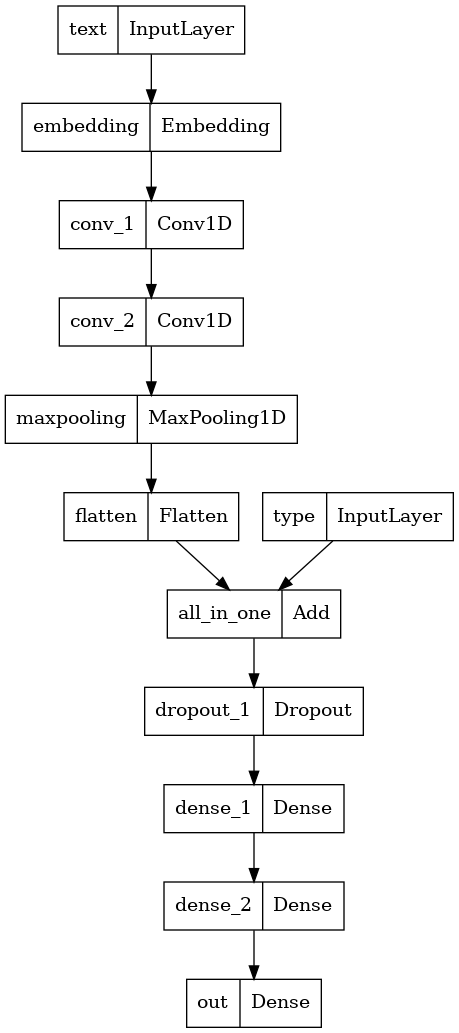

In [92]:
keras.utils.plot_model(model, "/tmp/BRUN0-Net.png") # evita di salvare la foto 

In [101]:
x_train



array([[array([   8,  935,   25,  130,  529,    2,  438,    1,  312,    5,    1,
                 19,  114,   61,  127, 3011,    1,  123,  804,   32,   14,  501,
               1460,    2,  104, 2544,  371,    2,  104, 2606,    4,   11,    2,
               2142,    1,  600, 1127,   20, 1616,   14, 2948, 2565,    0,    0,
                  0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                  0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                  0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                  0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                  0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                  0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                  0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                  0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                  0,    0,  